In [1]:
import librosa
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
import scipy.signal as sps
from tabulate import tabulate
import pandas as pd

# Prediction and Quantization
A simple signal processing system and its evaluation using commonly found metrics in signal processing and communications.

Parts
1. Using an IIR filter for "one-step-ahead" prediction
2. Using a quantizer to discretize sample values
3. Putting it all together
4. Bonus: Comparing performance

In [2]:
def signal_gen(frequency, amplitude, phase_degrees, duration, Fs):
    phase = phase_degrees * np.pi/180
    t  = np.arange(0,duration, 1/Fs) # X axis: Time & Samples
    return amplitude*np.sin(2*np.pi*frequency*t+phase), t

def dB(voltage):
    return 20 * np.log10(voltage)

def predict(signal, order):
    numerator = librosa.lpc(x, order) # Linear Filter Poles
    denominator = [1] 
    perr = sps.lfilter(numerator, denominator, x) 
    x_hat = x - perr
    return (x_hat, perr, numerator)

### Example Predictor

Linear Filter poles: [ 1.     -0.2835  0.7716]

         0       1      2       3       4       5      6       7       8  \
x      1.0 -1.0000  0.000  2.0000  1.0000 -1.0000 -2.000  0.0000  1.0000   
x_hat  0.0  0.2835 -1.055  0.7716  0.5669 -1.2597 -1.055  0.2047  1.5431   
err    1.0 -1.2835  1.055  1.2284  0.4331  0.2597 -0.945 -0.2047 -0.5431   

            9  
x      0.0000  
x_hat  0.2835  
err   -0.2835  
                0     1      2      3    4      5      6      7      8     9
x             1.0 -1.00  0.000  2.000  1.0 -1.000 -2.000  0.000  1.000  0.00
x_hat_manual  0.0  0.25 -1.107  0.857  0.5 -1.464 -1.107  0.357  1.714  0.25
err_manual    1.0 -1.25  1.107  1.143  0.5  0.464 -0.893 -0.357 -0.714 -0.25


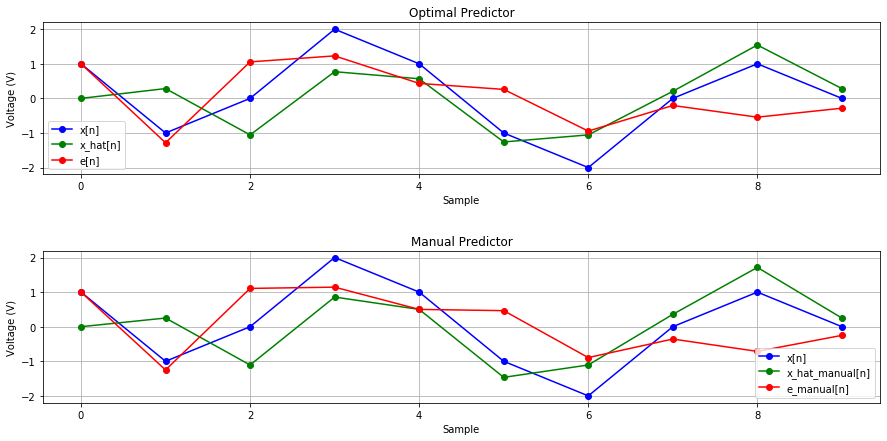

In [11]:
n = np.arange(0,10)
x = np.array([1.0,-1.0,0.0,2.0,1.0,-1.0,-2.0,0.0,1.0,0.0])
numerator_manual = [1.0000,-0.2500,0.8570]


# Optimal Coefficients
x_hat, perr, b = predict(x,2)


# Manual Coefficients
denominator = [1] 
perr_manual = sps.lfilter(numerator_manual, denominator, x) 
x_hat_manual = x - perr_manual


# Printer
print('Linear Filter poles: '+ str(np.round(b,4))+'\n')

col = ['x','x_hat','err']
data = np.round(np.append([x],[x_hat,perr], axis=0), 4)
df = pd.DataFrame(data, index=col)
print(df)

col = ['x','x_hat_manual','err_manual']
data = np.round(np.append([x],[x_hat_manual,perr_manual], axis=0), 4)
df = pd.DataFrame(data, index=col)
print(df)


# Graph
plt.figure('position', [15,7])
plt.subplots_adjust(hspace = .5)

plt.subplot(2,1,1)
plt.title('Optimal Predictor')
plt.plot(n, x, 'b-o', label='x[n]')
plt.plot(n, x_hat, 'g-o', label='x_hat[n]')
plt.plot(n, perr, 'r-o', label='e[n]')
plt.ylabel('Voltage (V)')
plt.xlabel('Sample')
plt.grid()
plt.legend()

plt.subplot(2,1,2)
plt.title('Manual Predictor')
plt.plot(n, x, 'b-o', label='x[n]')
plt.plot(n, x_hat_manual, 'g-o', label='x_hat_manual[n]')
plt.plot(n, perr_manual, 'r-o', label='e_manual[n]')
plt.ylabel('Voltage (V)')
plt.xlabel('Sample')
plt.grid()
plt.legend()

Linear Filter coeficients: [ 1.        -1.9076421  0.9675126]
Numerator of H(z):          [ 1.9076421 -0.9675126]


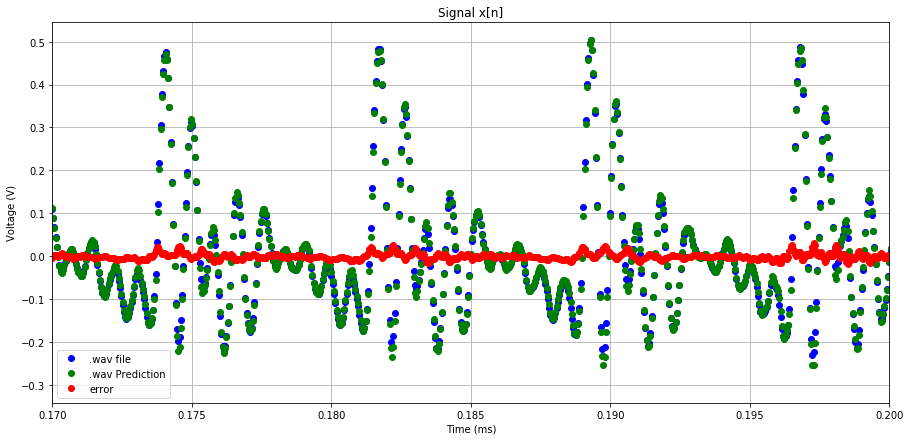

In [5]:
x, sr = librosa.load('snip.wav') # Signal time series and sampling rate
duration = np.size(x)/sr
period = 1/sr
t = np.arange(0,duration, period)
a = librosa.lpc(x, 2) # Linear Filter aficients
print('Linear Filter coeficients: '+ str(a))

numerator = -1 * np.delete(a, 0)
print('Numerator of H(z):          ' + str(numerator))
denominator = [1]
x_hat = sps.lfilter(numerator, denominator, x) 
x_hat = np.append(0,x_hat[0:-1])
e = x - x_hat

# Graph
plt.figure('position', [15,7])
# plt.subplots_adjust(hspace = .5)

# plt.subplot(2,1,1)
plt.title('Signal x[n]')
plt.plot(t, x, 'bo', label='.wav file')
plt.plot(t, x_hat, 'go', label='.wav Prediction')
plt.plot(t, e, 'ro', label='error')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (ms)')
plt.xlim(.17,.2)
plt.grid()
plt.legend()